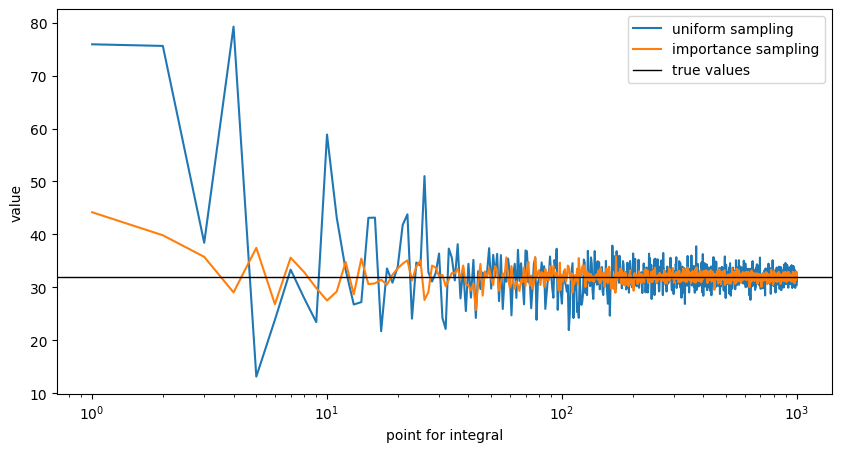

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

mu = 4  # Gaussian centroid for importance sampling, derived from the graph of the function
sigma_norm = 2  # Gaussian sigma

sigma = 2  # sigma of the function

N_max = 1000  # maximum number of points for integration

area_uni = []  # area with uniform sampling
area_norm = []  # area with normal sampling
number = []  # iterations

expected = 2 * sigma**4  # expected value

def function(x, sigma):  # Function to integrate
    return x**3 * np.exp(-(x**2) / (2 * sigma**2))

def Importance_sampling(N): #------------------------------------------------------------------------------------------------

    X = [] # vector of randomly generated numbers
 
    while len(X) < N:
        Xi = np.random.normal(mu, sigma_norm) # advantage: points are generated over the entire R
        if Xi >= 0 : 
            X.append(Xi) # select only R+

    X = np.array(X) # it's converted to an array because Python doesn't read it otherwise

    peso = (1 / (np.sqrt(2 * np.pi) * sigma_norm)) * np.exp(-((X - mu) ** 2) / (2 * sigma_norm ** 2))

    p_positive = 1 - norm.cdf(0, loc=mu, scale=sigma_norm) # for the importance sampling method, we need to account for the probability of the positive side of the Gaussian

        # Here the concept of importance sampling comes into play:
        # If we sampled directly from a uniform distribution, each point would contribute equally.
        # Here, however, the points are drawn from a Gaussian distribution.
        # To compensate for this choice, we divide by the density of the sampling distribution (the PDF of the Gaussian).

    weighted_values = function(X, sigma) / (peso / p_positive)

    integral = np.mean(weighted_values)

    return integral


def gen_uniforme (N) : #------------------------------------------------------------------------------------------------

    x_min = 0   #into uniform generetion i have to put the extremis
    x_max = 5*sigma

    Y = np.random.uniform(x_min, x_max, N) # crude method

    integral = (x_max - x_min) * np.mean(function(Y, sigma))

    return integral

for N in range(N_max):
    number.append(N)
    area_norm.append(Importance_sampling(N))
    area_uni.append(gen_uniforme(N))


plt.figure(figsize=(10, 5))
plt.xscale('log')
plt.plot(number, area_uni, label ="uniform sampling")
plt.plot(number, area_norm, label = "importance sampling")
plt.xlabel("point for integral")
plt.ylabel("value")
plt.axhline(y=2 * sigma**4, color='black', linestyle='-', linewidth=1, label ="true values")
plt.legend() 
plt.show()

In [5]:
from astroML import stats as astroMLstats

def bins_num (X) :

    sigmaG2 = astroMLstats.sigmaG(X) # quantile at 75 - quantile at 25
    binsize = 2.7 * sigmaG2 / (len(X)**(1/3)) #Freedman-Diaconis
    N = (max(X) - min(X))/binsize

    return int(N+2)

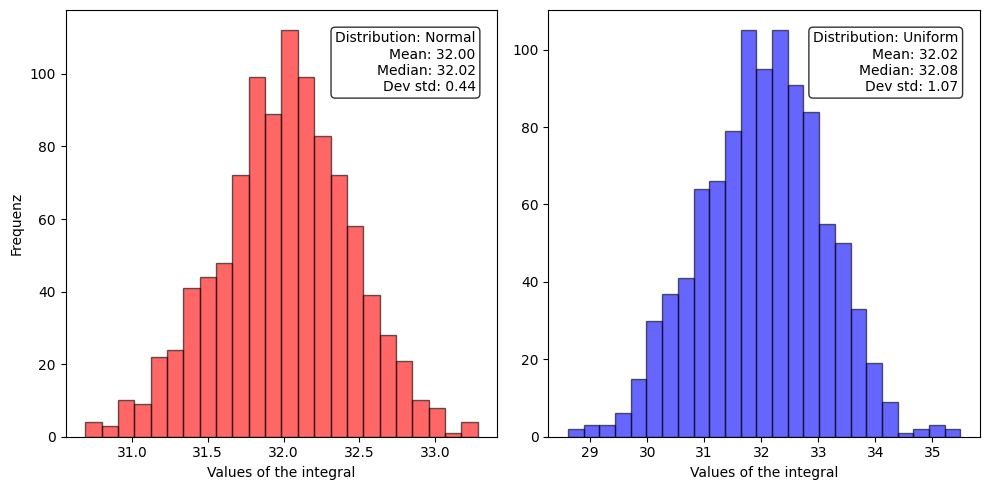

In [6]:

ripetizioni = 1000 #ripetition of the integral

area_uni = []
area_norm = []

for i in range(ripetizioni):
    area_norm.append(Importance_sampling(N_max))
    area_uni.append(gen_uniforme(N_max))   

mean_norm = np.mean(area_norm)
median_norm = np.median(area_norm)
std_norm = np.std(area_norm)

mean_uni = np.mean(area_uni)
median_uni = np.median(area_uni)
std_uni = np.std(area_uni)

plt.figure(figsize=(10, 5))

# histogram for the two distributionù

plt.subplot(1,2,1)
plt.hist(area_norm, bins = bins_num(area_norm), color='red', alpha=0.6, edgecolor='black')
plt.xlabel("Values of the integral")
plt.ylabel("Frequenz")
plt.text(0.95, 0.95, 
          f"Distribution: Normal\nMean: {mean_norm:.2f}\nMedian: {median_norm:.2f}\nDev std: {std_norm:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         fontsize=10,
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))


plt.subplot(1,2,2)
plt.hist(area_uni, bins = bins_num(area_uni), color='blue', alpha=0.6, label='Uniforme', edgecolor='black')
plt.xlabel("Values of the integral")
plt.text(0.95, 0.95, 
        f"Distribution: Uniform\nMean: {mean_uni:.2f}\nMedian: {median_uni:.2f}\nDev std: {std_uni:.2f}",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         fontsize=10,
         bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()